# XG Boost

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb 
import sklearn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    precision_recall_curve,
    auc
)

In [5]:
X_train = pd.read_csv('../Data/f2_data/f2_X_train.csv')
y_train = pd.read_csv('../Data/f2_data/f2_y_train.csv')

X_val = pd.read_csv('../Data/f2_data/f2_X_val.csv')
y_val = pd.read_csv('../Data/f2_data/f2_y_val.csv')

X_test = pd.read_csv('../Data/f2_data/f2_X_test.csv')  
y_test = pd.read_csv('../Data/f2_data/f2_y_test.csv')

In [6]:
X_train.head()

,dwell_0,dwell_1,dwell_2,log_mean_0,log_mean_1,log_mean_2,log_std_0,log_std_1,log_std_2,base_1_A,...,base_2_T,base_3_A,base_3_G,base_6_A,base_6_C,base_6_T,base_7_A,base_7_C,base_7_G,base_7_T
0,119.626866,126.970149,81.335821,-4.880373,-4.760620,-5.009353,1.589266,1.923420,1.406697,1,...,0,0,1,0,1,0,1,0,0,0
1,103.245333,123.093333,82.341333,-4.693492,-5.071426,-5.112690,1.305410,1.935764,1.570337,0,...,1,0,1,0,1,0,0,1,0,0
2,101.653810,96.965163,86.640435,-4.710294,-4.959351,-5.066744,0.744468,1.010792,0.930151,0,...,0,1,0,1,0,0,1,0,0,0
3,92.394118,92.967647,84.441176,-5.061619,-5.050722,-4.853481,0.708905,0.852047,0.672494,0,...,1,1,0,0,1,0,0,1,0,0
4,106.682025,121.106329,86.660000,-5.034657,-4.870927,-4.946987,1.199370,1.795066,1.223444,0,...,1,0,1,1,0,0,1,0,0,0


### helper function to evaluate metrics

In [3]:
def evaluate_model(model, X, y, dataset_name):
    """Evaluate model and return comprehensive metrics"""
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y, y_pred)
    
    # Calculate metrics using sklearn functions
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)
    
    # Calculate PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y, y_pred_proba)
    pr_auc = auc(recall_vals, precision_vals)
    
    # Get confusion matrix components
    tn, fp, fn, tp = cm.ravel()
    
    print(f"{dataset_name} Set Metrics")
    
    print("Confusion Matrix:\n", cm)    
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  F1-Score:   {f1:.4f}")
    print(f"  Accuracy:   {accuracy:.4f}")
    print(f"  ROC-AUC:    {roc_auc:.4f}")
    print(f"  PR-AUC:     {pr_auc:.4f}")
    
    return {
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'precision_curve': precision_vals,
        'recall_curve': recall_vals
    }

## Baseline model

In [52]:
baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42
)

baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

baseline_val_results = evaluate_model(baseline_model, X_val, y_val, "Validation")
baseline_test_results = evaluate_model(baseline_model, X_test, y_test, "Test")

Validation Set Metrics
Confusion Matrix:
 [[20730   217]
 [  697   287]]
  Precision:  0.5694
  Recall:     0.2917
  F1-Score:   0.3858
  Accuracy:   0.9583
  ROC-AUC:    0.8904
  PR-AUC:     0.4130
Test Set Metrics
Confusion Matrix:
 [[11658   130]
 [  269   127]]
  Precision:  0.4942
  Recall:     0.3207
  F1-Score:   0.3890
  Accuracy:   0.9673
  ROC-AUC:    0.8955
  PR-AUC:     0.3453


## SMOTE

In [6]:
# Check class distribution before SMOTE
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nOriginal training data distribution:")
print(f"Class 0: {counts[0]} ({counts[0]/len(y_train)*100:.2f}%)")
print(f"Class 1: {counts[1]} ({counts[1]/len(y_train)*100:.2f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(f"\nBalanced training data distribution:")
print(f"Class 0: {counts[0]} ({counts[0]/len(y_train_balanced)*100:.2f}%)")
print(f"Class 1: {counts[1]} ({counts[1]/len(y_train_balanced)*100:.2f}%)")


Original training data distribution:
Class 0: 83628 (95.33%)
Class 1: 4095 (4.67%)

Balanced training data distribution:
Class 0: 83628 (50.00%)
Class 1: 83628 (50.00%)


## Train balanced model

In [51]:
balanced_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

balanced_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    verbose=False
)

balanced_val_results = evaluate_model(balanced_model, X_val, y_val, "Validation")
balanced_test_results = evaluate_model(balanced_model, X_test, y_test, "Test")

Validation Set Metrics
Confusion Matrix:
 [[19006  1941]
 [  307   677]]
  Precision:  0.2586
  Recall:     0.6880
  F1-Score:   0.3759
  Accuracy:   0.8975
  ROC-AUC:    0.8953
  PR-AUC:     0.4062
Test Set Metrics
Confusion Matrix:
 [[10734  1054]
 [  123   273]]
  Precision:  0.2057
  Recall:     0.6894
  F1-Score:   0.3169
  Accuracy:   0.9034
  ROC-AUC:    0.8965
  PR-AUC:     0.3505


## Hyperparameter Tuning

### Tune n_estimators

In [ ]:
parameters_n_estimators = {'n_estimators': [50, 100, 150, 200, 250, 300]}

model = xgb.XGBClassifier(
    random_state=42,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='aucpr'
)

grid_search_n_estimators = GridSearchCV(
    model, 
    param_grid=parameters_n_estimators, 
    cv=3, 
    scoring='average_precision', 
    verbose=1
)
grid_search_n_estimators.fit(X_train_balanced, y_train_balanced)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


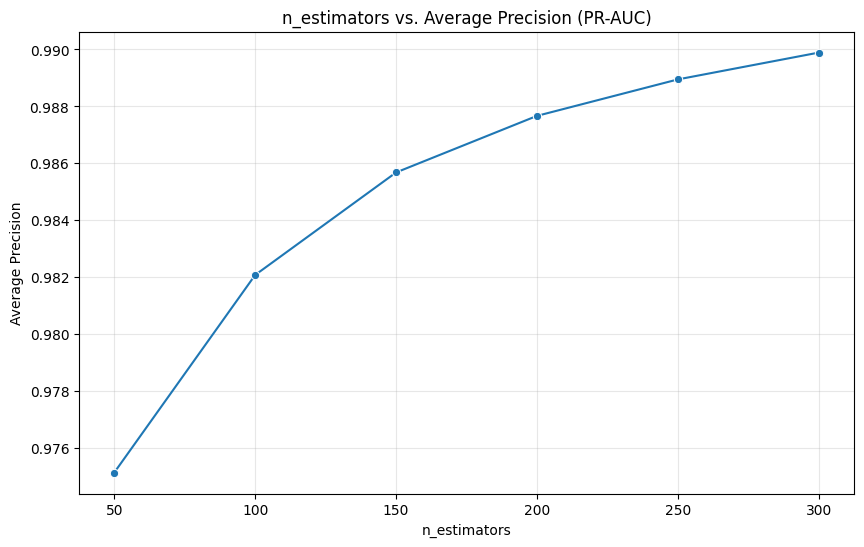

In [29]:
plt.figure(figsize=(10, 6))

# Plotting n_estimators vs. average precision
sns.lineplot(x=[50, 100, 150, 200, 250, 300], y=grid_search_n_estimators.cv_results_['mean_test_score'], marker='o')
plt.title('n_estimators vs. Average Precision (PR-AUC)')
plt.xlabel('n_estimators')
plt.ylabel('Average Precision')
plt.grid(True, alpha=0.3)
plt.show()

The improvement becomes more apparent as the number of estimators increases from 50 to 150. Beyond this point, however, the improvement becomes more subtle. Therefore, we decide to proceed with n_estimators=150 for the subsequent tuning steps.

### Tune max_depth

In [36]:
parameters_max_depth = {
    'max_depth': [3, 4, 5, 6, 7, 8]
}

model = xgb.XGBClassifier(
    n_estimators=150,  # Use the best n_estimators from previous tuning
    random_state=42,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='aucpr'
)

grid_search_max_depth = GridSearchCV(
    model, 
    param_grid=parameters_max_depth, 
    cv=3, 
    scoring='average_precision',
    verbose=1
)
grid_search_max_depth.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'max_depth': [3, 4, ...]}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


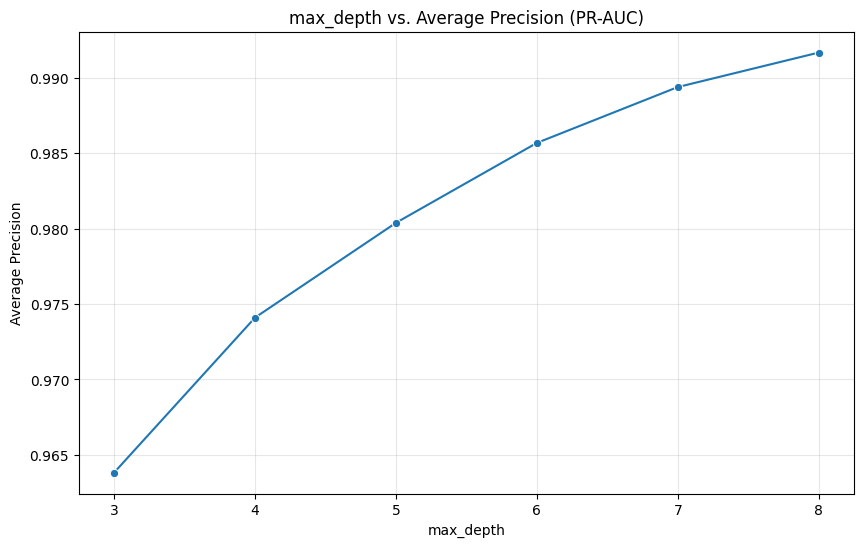

In [37]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. average precision
sns.lineplot(x=[3, 4, 5, 6, 7, 8], y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. Average Precision (PR-AUC)')
plt.xlabel('max_depth')
plt.ylabel('Average Precision')
plt.grid(True, alpha=0.3)
plt.show()

The results indicate that the model's performance improves as max_depth increases. However, this improvement may be attributed to the model overfitting to the training data. To mitigate this risk and prevent overfitting, we choose a smaller max_depth and retain the default setting: max_depth=6.

### Tune learning_rate

In [38]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=6,
    random_state=42,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='aucpr'
)

grid_search_learning_rate = GridSearchCV(
    model, 
    param_grid=parameters_learning_rate, 
    cv=3, 
    scoring='average_precision',
    verbose=1
)
grid_search_learning_rate.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...]}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


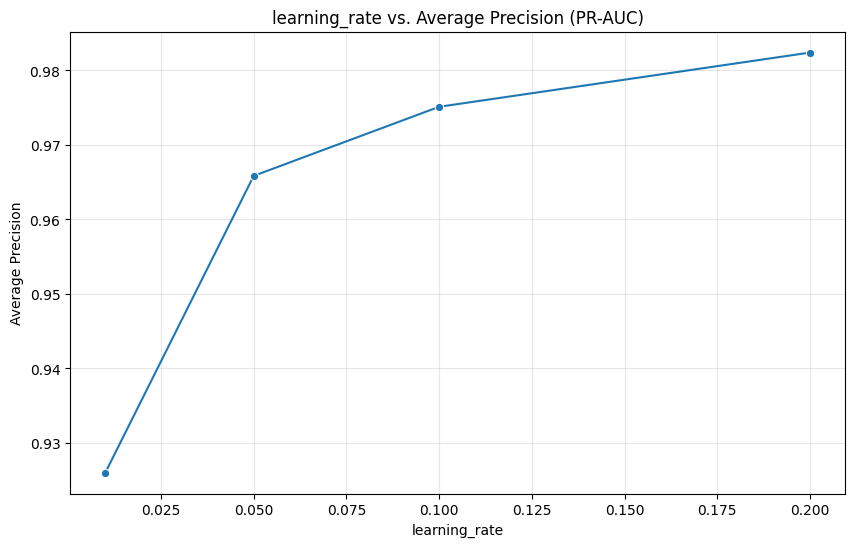

In [39]:
plt.figure(figsize=(10, 6))

# Plotting learning_rate vs. average precision
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. Average Precision (PR-AUC)')
plt.xlabel('learning_rate')
plt.ylabel('Average Precision')
plt.grid(True, alpha=0.3)
plt.show()

The optimal solution for learning_rate remains at 0.1, as further increases result in diminishing improvements.

### Tune min_child_weight - controls overfitting

In [40]:
parameters_min_child = {
    'min_child_weight': [1, 3, 5, 7, 10]
}

model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist',
    objective='binary:logistic',
    eval_metric='aucpr'
)

grid_search_min_child = GridSearchCV(
    model, 
    param_grid=parameters_min_child, 
    cv=3, 
    scoring='average_precision',
    verbose=1
)
grid_search_min_child.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'min_child_weight': [1, 3, ...]}"
,scoring,'average_precision'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


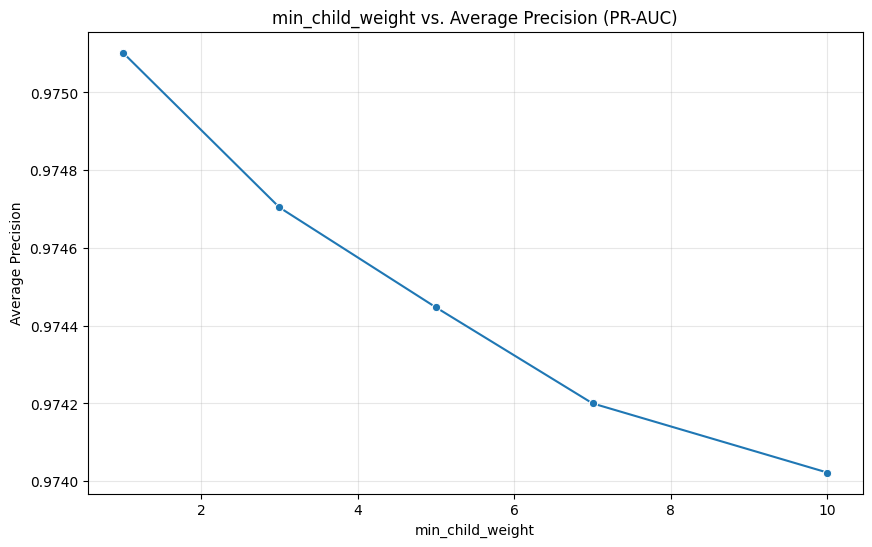

In [41]:
plt.figure(figsize=(10, 6))

# Plotting min_child_weight vs. average precision
sns.lineplot(x=[1, 3, 5, 7, 10], y=grid_search_min_child.cv_results_['mean_test_score'], marker='o')
plt.title('min_child_weight vs. Average Precision (PR-AUC)')
plt.xlabel('min_child_weight')
plt.ylabel('Average Precision')
plt.grid(True, alpha=0.3)
plt.show()

Since all values (1 - 10) of min_child_weight gives nearly identical PR-AUC scores, this parameter doesn't significantly affect the model's performance. 
Choose min_child_weight = 1

## Train final model with best parameters

In [7]:
final_model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=1,  # Classes balanced by SMOTE
    random_state=42,
    tree_method='hist'
)

# Train final model
final_model.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Evaluate final model
final_val_results = evaluate_model(final_model, X_val, y_val, "Validation")
final_test_results = evaluate_model(final_model, X_test, y_test, "Test")

Validation Set Metrics
Confusion Matrix:
 [[19174  1773]
 [  307   677]]
  Precision:  0.2763
  Recall:     0.6880
  F1-Score:   0.3943
  Accuracy:   0.9052
  ROC-AUC:    0.8988
  PR-AUC:     0.4156
Test Set Metrics
Confusion Matrix:
 [[10842   946]
 [  127   269]]
  Precision:  0.2214
  Recall:     0.6793
  F1-Score:   0.3340
  Accuracy:   0.9119
  ROC-AUC:    0.9011
  PR-AUC:     0.3605


In [ ]:
# Original GridSearchCV Method (Not Executed)
''' from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create base model for tuning
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=1,  # Classes balanced by SMOTE
    random_state=42,
    tree_method='gpu_hist'
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='average_precision',  # PR-AUC
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(
    X_train_balanced, y_train_balanced,
    eval_set=[(X_val, y_val)],
    verbose=False
)
print("Best params:", grid_search.best_params_) '''
    

' from sklearn.model_selection import GridSearchCV\n\n# Define parameter grid for hyperparameter tuning\nparam_grid = {\n    \'max_depth\': [4, 6, 8],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'n_estimators\': [100, 200, 300],\n    \'min_child_weight\': [1, 3, 5],\n    \'gamma\': [0, 0.1, 0.2],\n    \'subsample\': [0.7, 0.8, 0.9],\n    \'colsample_bytree\': [0.7, 0.8, 0.9]\n}\n\n# Create base model for tuning\nxgb_base = xgb.XGBClassifier(\n    objective=\'binary:logistic\',\n    eval_metric=\'aucpr\',\n    scale_pos_weight=1,  # Classes balanced by SMOTE\n    random_state=42,\n    tree_method=\'gpu_hist\'\n)\n\ngrid_search = GridSearchCV(\n    estimator=xgb_base,\n    param_grid=param_grid,\n    scoring=\'average_precision\',  # PR-AUC\n    cv=3,\n    verbose=2,\n    n_jobs=-1\n)\n\ngrid_search.fit(\n    X_train_balanced, y_train_balanced,\n    eval_set=[(X_val, y_val)],\n    verbose=False\n)\nprint("Best params:", grid_search.best_params_) '

## Intermediate Leaderboard submission

In [8]:
dataset0 = pd.read_csv('../Data/full_feature_set/f2_noskew_ohe.csv')
dataset1 = pd.read_csv('../Data/unseen_test/test1_mean_transformed.csv')
dataset2 = pd.read_csv('../Data/unseen_test/test2_mean_transformed.csv')

In [10]:
# see the shape of the datasets
print("Dataset 0 shape:", dataset0.shape)
print("Dataset 1 shape:", dataset1.shape)
print("Dataset 2 shape:", dataset2.shape)

Dataset 0 shape: (121838, 29)
Dataset 1 shape: (90810, 28)
Dataset 2 shape: (1323, 27)


In [12]:
# see the column names of the datasets
print("Dataset 0 columns:", dataset0.columns)
print("Dataset 1 columns:", dataset1.columns)   
print("Dataset 2 columns:", dataset2.columns)

Dataset 0 columns: Index(['transcript_id', 'transcript_position', 'gene_id', 'dwell_0', 'dwell_1',
       'dwell_2', 'log_mean_0', 'log_mean_1', 'log_mean_2', 'log_std_0',
       'log_std_1', 'log_std_2', 'base_1_A', 'base_1_C', 'base_1_G',
       'base_1_T', 'base_2_A', 'base_2_G', 'base_2_T', 'base_3_A', 'base_3_G',
       'base_6_A', 'base_6_C', 'base_6_T', 'base_7_A', 'base_7_C', 'base_7_G',
       'base_7_T', 'label'],
      dtype='object')
Dataset 1 columns: Index(['transcript_id', 'transcript_position', 'dwell_0', 'dwell_1', 'dwell_2',
       'label', 'log_mean_0', 'log_mean_1', 'log_mean_2', 'log_std_0',
       'log_std_1', 'log_std_2', 'base_1_A', 'base_1_C', 'base_1_G',
       'base_1_T', 'base_2_A', 'base_2_G', 'base_2_T', 'base_3_A', 'base_3_G',
       'base_6_A', 'base_6_C', 'base_6_T', 'base_7_A', 'base_7_C', 'base_7_G',
       'base_7_T'],
      dtype='object')
Dataset 2 columns: Index(['transcript_id', 'transcript_position', 'dwell_0', 'dwell_1', 'dwell_2',
       'log_

In [22]:
def generate_predictions(model, df, output_filename, has_label=False):
    """Generate predictions and save to CSV"""
    
    # Extract IDs and positions
    transcript_ids = df['transcript_id'].values
    transcript_positions = df['transcript_position'].values
    
    # Get feature columns
    feature_columns = [col for col in df.columns 
                      if col not in ['transcript_id', 'transcript_position', 'gene_id', 'label']]
    
    # Get features and predict
    X = df[feature_columns].values
    scores = model.predict_proba(X)[:, 1]
    
    # Create and save predictions
    predictions_df = pd.DataFrame({
        'transcript_id': transcript_ids,
        'transcript_position': transcript_positions,
        'score': scores
    })
    
    predictions_df.to_csv(output_filename, index=False)
    print(f"Saved: {output_filename} ({len(predictions_df)} samples)")
    
    return predictions_df


# Generate predictions for all 3 datasets
predictions_0 = generate_predictions(final_model, dataset0, 'dna1234_dataset0_2.csv', has_label=True)
predictions_1 = generate_predictions(final_model, dataset1, 'dna1234_datatset1_2.csv', has_label=False)
predictions_2 = generate_predictions(final_model, dataset2, 'dna1234_datatset2_2.csv', has_label=False)

print("Done!")

Saved: dna1234_dataset0_2.csv (121838 samples)
Saved: dna1234_datatset1_2.csv (90810 samples)
Saved: dna1234_datatset2_2.csv (1323 samples)
Done!
